# 1. От классификации к детекции: постановка задачи

**Компьютерное зрение (Computer Vision, CV)** — часть нашей повседневности: смартфоны распознают лицо и разблокируют экран, беспилотные автомобили видят дорогу, людей и другие машины, медицина применяет CV для анализа рентгеновских снимков, промышленность — для контроля качества, а сельское хозяйство — для мониторинга роста и состояния урожая.


## Задачи компьютерного зрения

Основных задачи три: классификация, локализация и детекция.

**Классификация**

Классификация — фундаментальная и, возможно, самая интуитивно понятная задача в компьютерном зрении. Суть её в том, чтобы научить машину отвечать на вопрос: «Что является основным объектом на изображении?». Эта задача стала опорной точкой развития всего машинного обучения.

Модель предполагает, что на изображении доминирует один смысловой объект. Если на фото крупным планом изображён золотистый ретривер, правильным ответом будет «собака». Даже если на заднем плане виден кусок дивана или дерева, модель сфокусируется на главном объекте и проигнорирует контекст. Выход такой модели — название класса и степень уверенности в ответе — вероятность. 


```py
{"class": "dog", "confidence": 0.96}
```

**Локализация**

Анализируя изображение, мы хотим не просто узнать, какой объект изображён на картинке, но и где именно он расположен. Это задача локализации. В этом случае модель выдаёт не только тип объекта и уверенность в ответе, но и четыре числа, описывающие рамку вокруг объекта (например, координаты углов рамки: x_min, y_min, x_max, y_max).

Локализация также работает для одного объекта. Если на картинке несколько объектов (например, кошка, собака и попугай), то модель, обученная для локализации и классификации, распознает только одного из них и выдаст результат:

```py
{class: "cat", confidence: 0.93, bounding_box: [450, 200, 580, 330]}.
```

**Детекция**

Детекция решает самую сложную задачу — находит и определяет все объекты на картинке, независимо от их количества и типов. Детектор просматривает всю сцену и выдаёт список найденных объектов. 

Результат работы такой модели выглядит как сложный список, например: 

```py
[{class: "person", ...}, {class: "person", ...}, {class: "car", ...}]
```

Именно детекция позволяет беспилотным автомобилям ориентироваться на дороге, системам безопасности — следить за нарушителями, а роботам на складе — находить нужные товары.

## Интерпретация выходных данных детектора

Детектор выдаёт: класс, рамку и уверенность.

В задаче локализации выделить объект на изображении помогает «рамка». В компьютерном зрении эти рамки называют ограничивающими рамками, а чаще — bounding boxes (англ. — «ограничивающие коробки»).

**Ограничивающие рамки (англ. Bounding boxes)**

Bounding box — это прямоугольник, который очерчивает найденный объект. Он обычно задаётся четырьмя числами. Есть два популярных формата задания этих координат:

1. Через координаты двух противоположных углов — `[x_min, y_min, y_min, y_max]`. 

Здесь: 

 - x_min — координата по оси X левого верхнего угла рамки,
 - y_min — координата по оси Y левого верхнего угла рамки,
 - x_max — координата по оси X правого нижнего угла рамки,
 - y_max — координата по оси Y правого нижнего угла рамки.

Система координат в компьютерном зрении обычно начинается в левом верхнем углу изображения: ось X идёт вправо, ось Y — вниз.

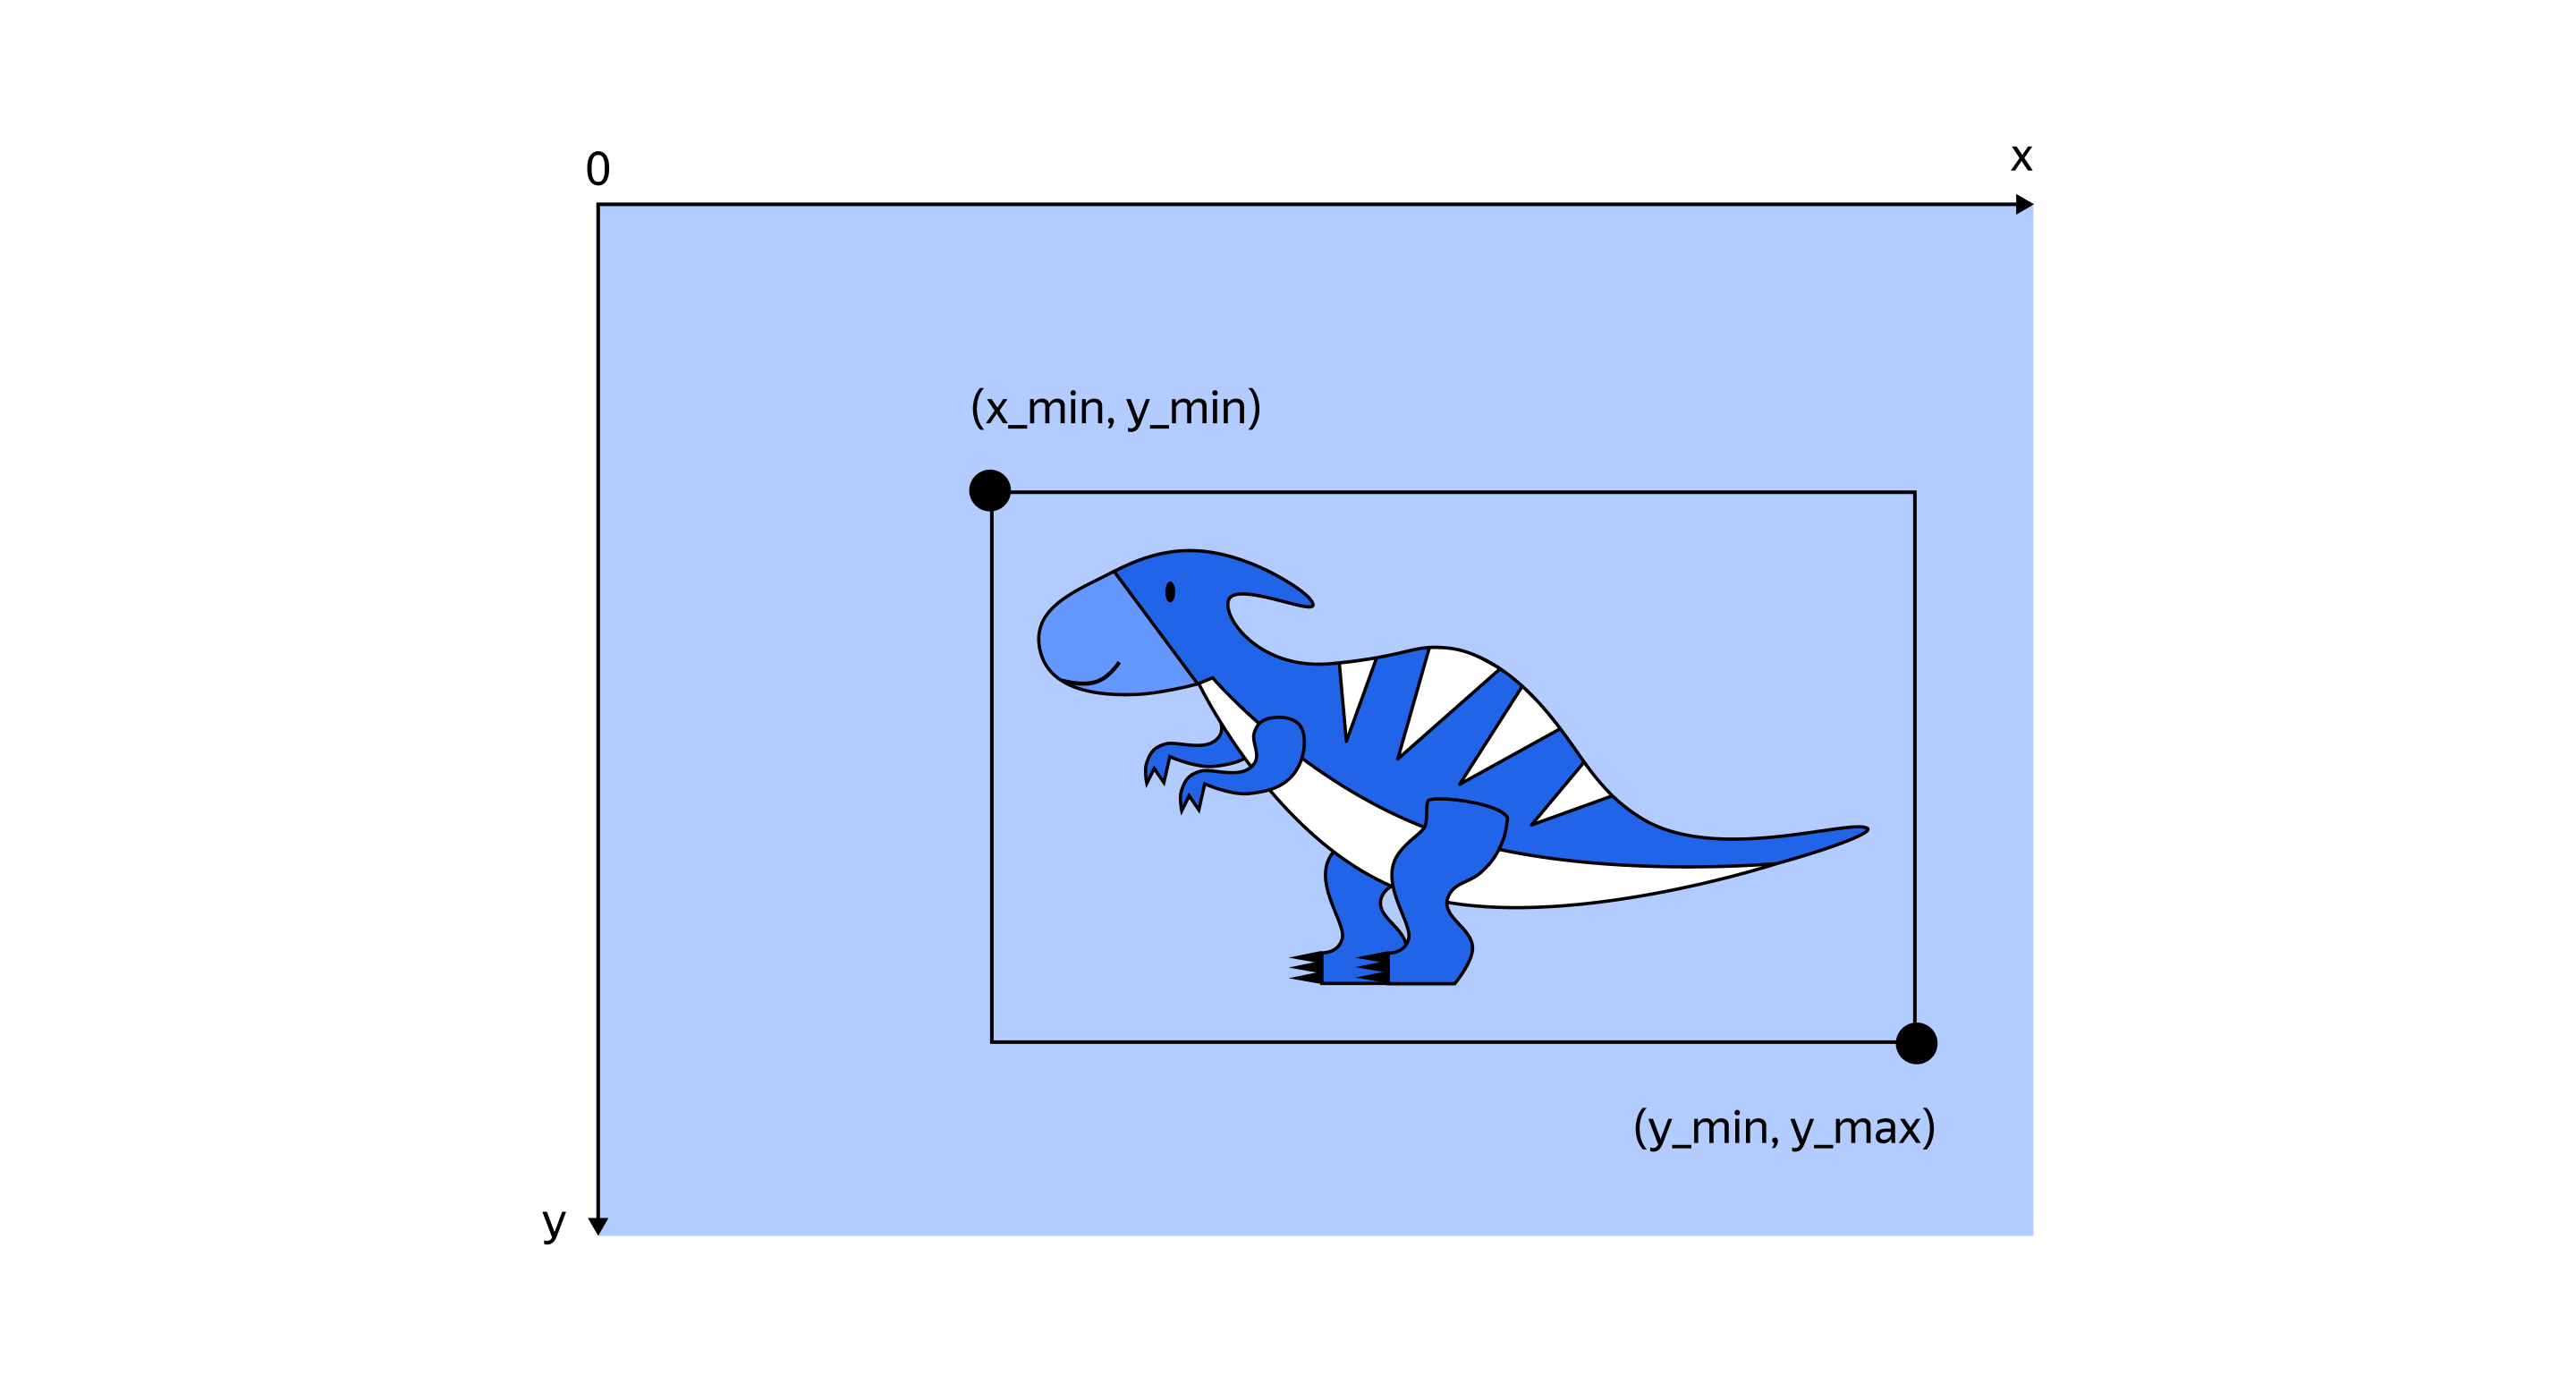

In [2]:
from ml_dl_experiments import show_image_from_source

source: str = "ml_dl/cv/bbox.png"

show_image_from_source(
    path=source,
    width=700,
    height=700
)

2. Через координаты центра и размеры рамки — `[x_center, y_center, width, height]`. 

Здесь:

- x_center — координата X центра рамки,
- y_center — координата Y центра рамки,
- width — ширина рамки,
- height — высота рамки.

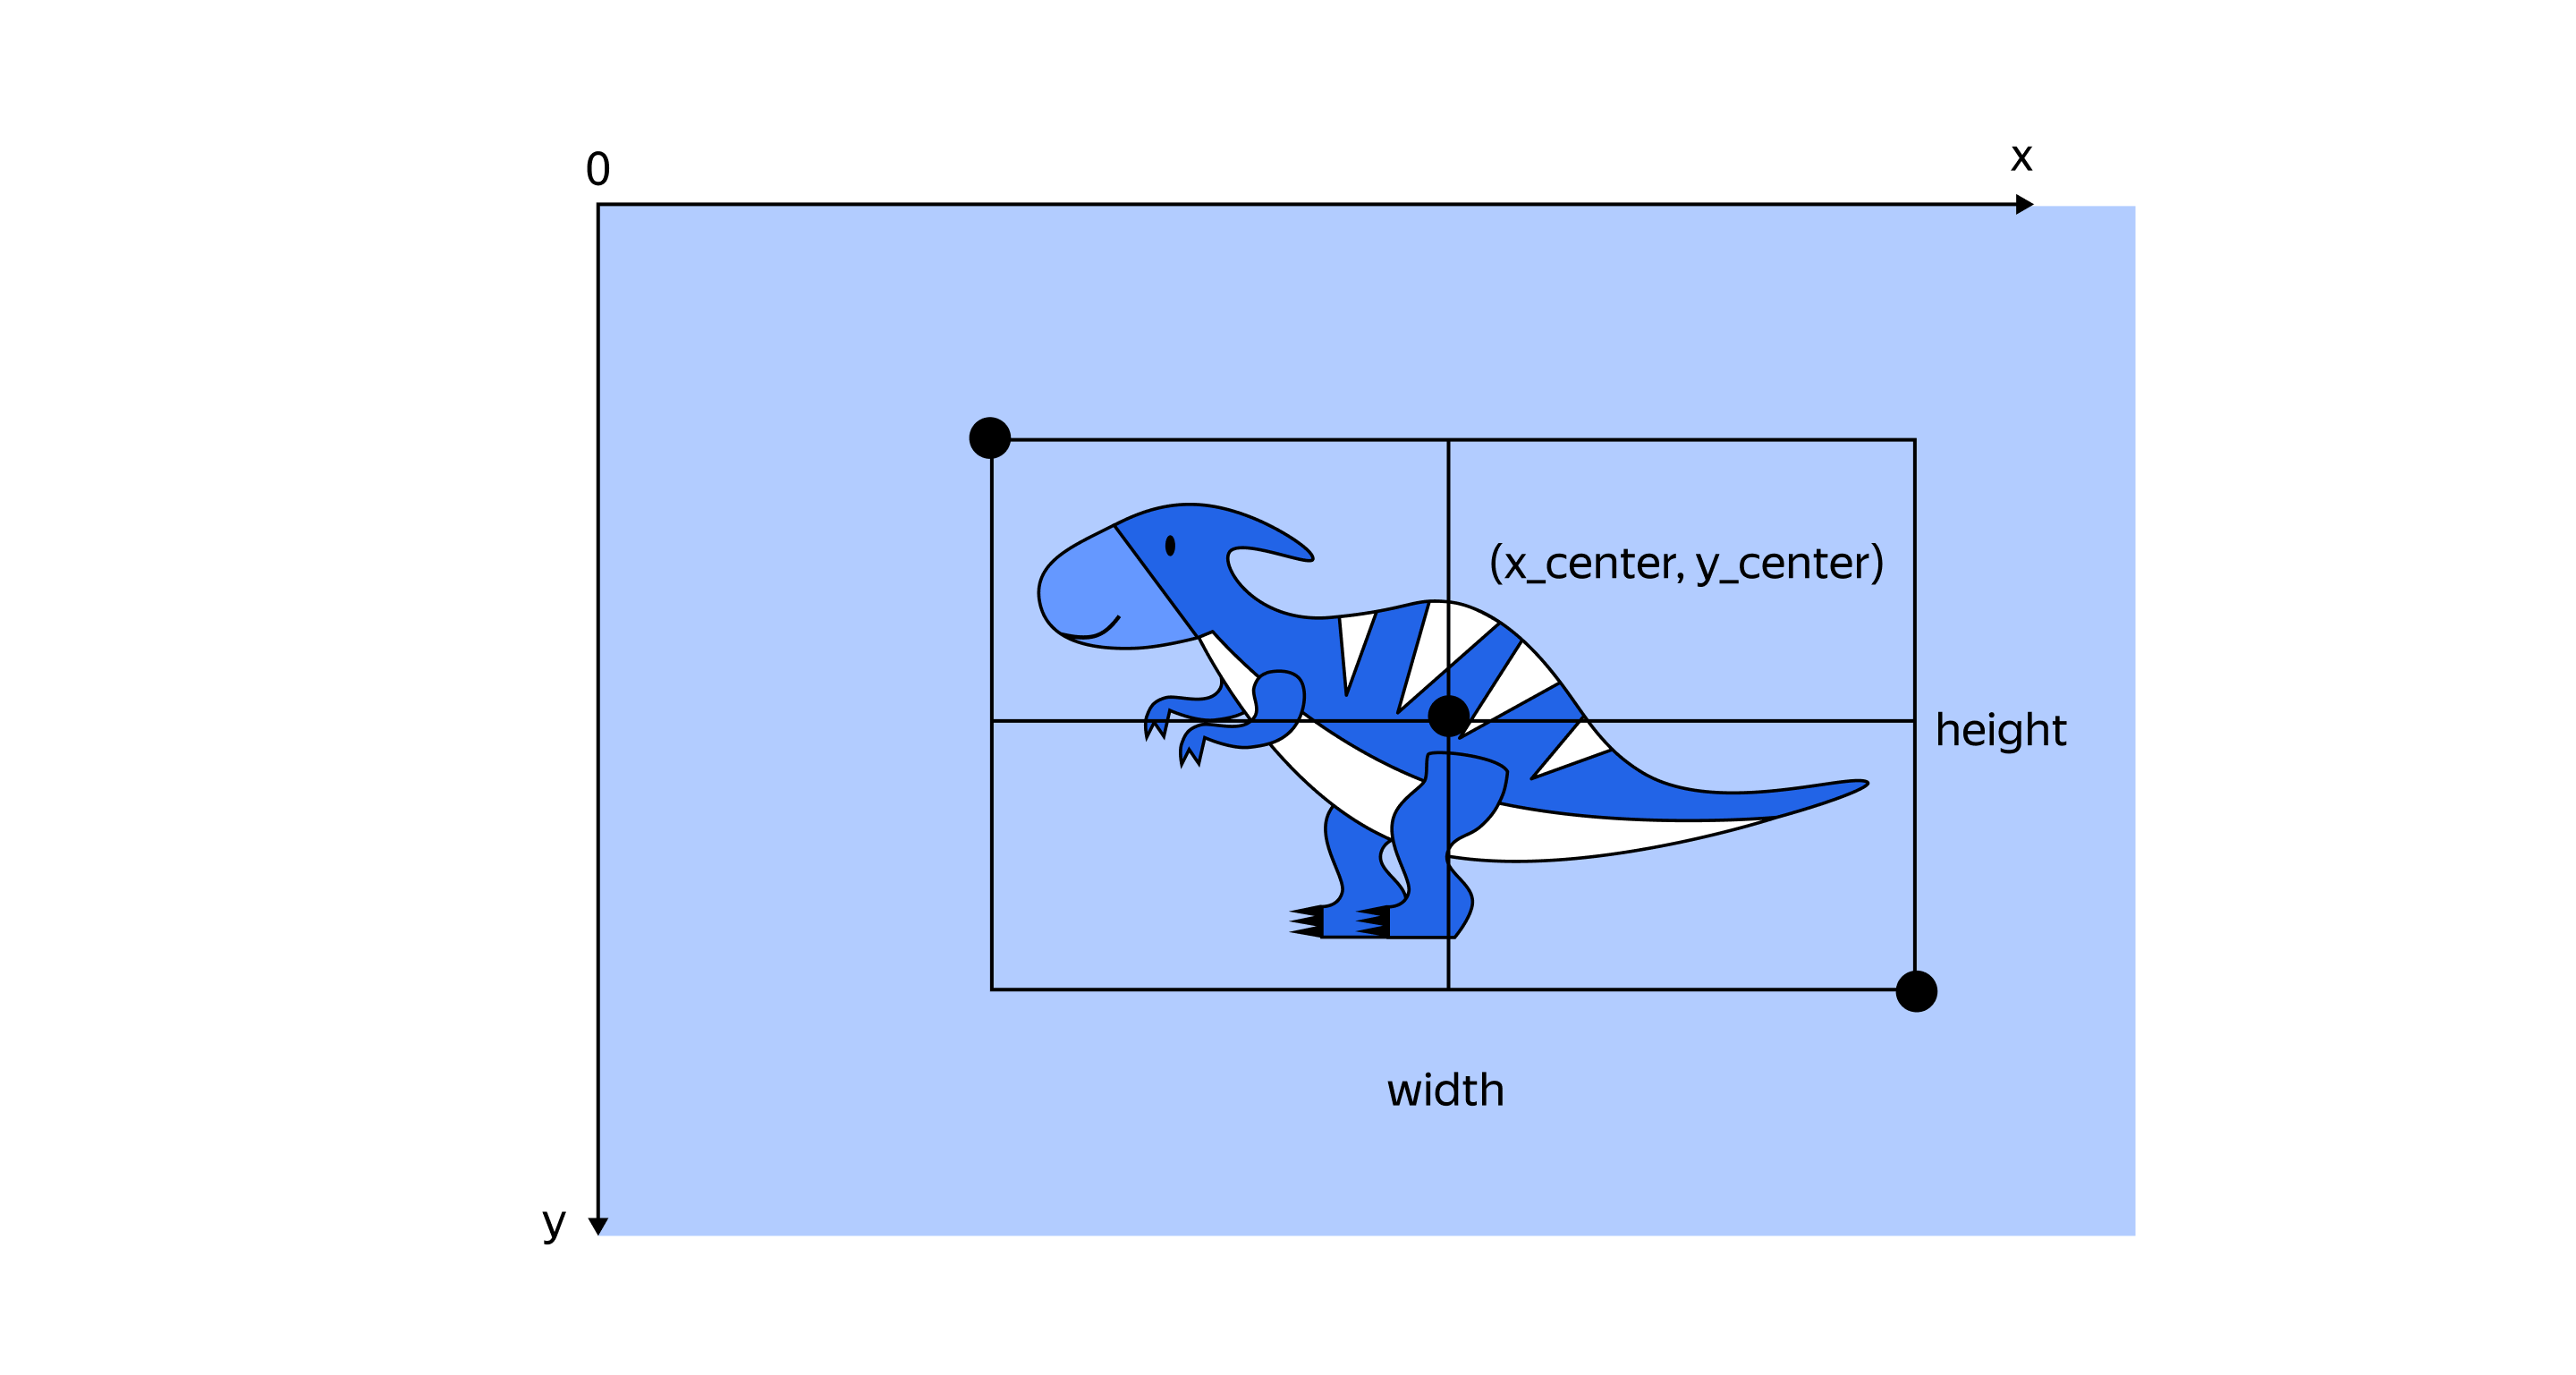

In [3]:
source: str = "ml_dl/cv/bbox2.png"

show_image_from_source(
    path=source,
    width=700,
    height=700
)

Этот формат часто используется в таких моделях, как YOLO, потому что он удобнее для вычислений внутри нейросети.

Кроме самих координат рамки (bounding box), модель для каждого найденного объекта сообщает значение уверенности (англ. Confidence Score).

**Значение уверенности (англ. Confidence Score)**

Это число от 0.0 до 1.0, которое показывает, насколько модель «уверена» в своём предсказании. Его можно интерпретировать как вероятность.

Интуитивно это можно понимать так:

- Значение, близкое к 1.0, означает максимальную уверенность. Это как если бы модель сказала: «Я на 99% уверена, что в этой рамке находится кот».
    
- Значение, близкое к 0.0, означает почти полное отсутствие уверенности. Сообщение от модели: «Я что-то здесь выделила, но с вероятностью 99% это просто фон или случайный шум».

В реальности модель генерирует сотни, а то и тысячи потенциальных рамок с очень низкой уверенностью. Чтобы отфильтровать «мусор» (ложные срабатывания), устанавливают порог уверенности и в дальнейшую работу берут только объекты, в которых модель более «уверена».

Итак, модель нашла объект, определила его границы и оценила свою уверенность в этом. Остаётся последний вопрос: «Что именно нашла модель?».

**ID класса (англ. Class ID)**

Модели оперируют не названиями «кот» или «собака», а числами. ID класса — это целое число, которое соответствует определённому классу объектов.

При обучении модели-детектора создаётся «словарь» или карта классов.

Например, карта классов может быть такой: `{0: 'person', 1: 'bicycle', 2: 'car', ..., 16: 'cat', 17: 'dog', ...}`. 

Здесь ID число 0 ассоциируется с классом человек ('``person``'), 2 — класс велосипед ('``bycicle``') и так далее.

Из существующей картинки, сделаем размеченную, чтобы понять, что именно мы получаем и в каком случае

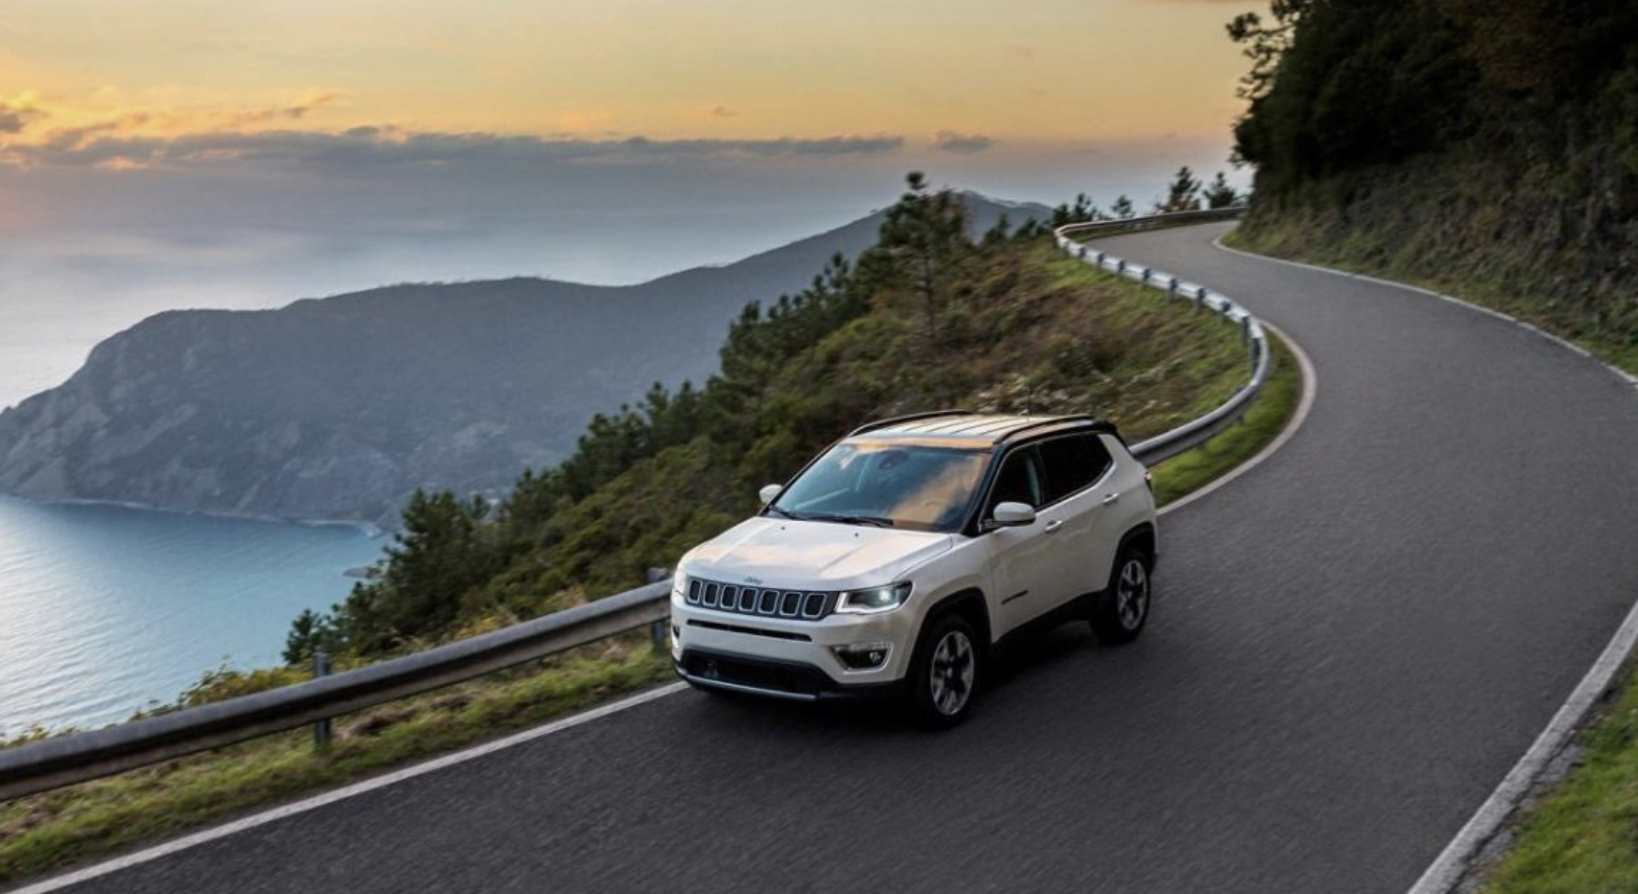

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy

from ml_dl_experiments import settings

image: str = settings.SOURCE_PATH + "ml_dl/cv/test_image1.png"
show_image_from_source(
    path="ml_dl/cv/test_image1.png",
    width=700,
    height=700
)

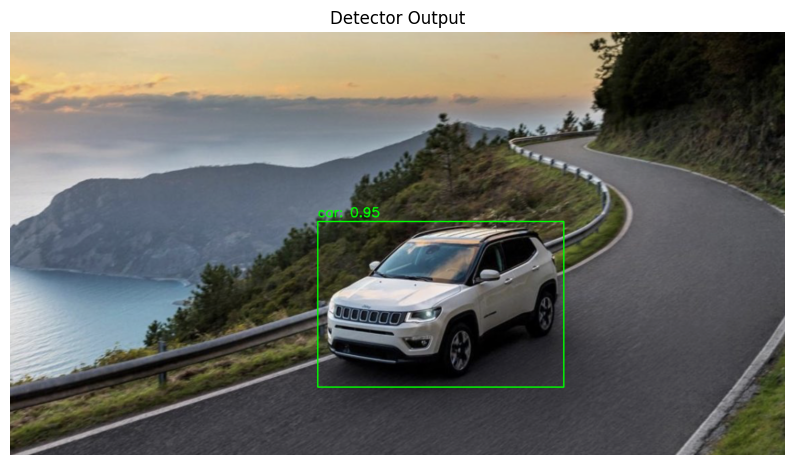

In [7]:
# [x_min, y_min, x_max, y_max]
bounding_box = [650, 400, 1170, 750]
class_name = "car"
confidence_score = 0.95


# Загрузите изображение с помощью OpenCV
image_data = cv2.imread(image)
# OpenCV загружает изображения в формате BGR. Для Matplotlib нужно его конвертировать в RGB.
image_rgb = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)

# Получите координаты из массива bounding_box
x_min, y_min, x_max, y_max = bounding_box

# Нарисуйте прямоугольник на изображении
# Используйте функцию cv2.rectangle()
cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Добавьте текст (название класса и уверенность)
# Используйте функцию cv2.putText()
text = f"{class_name}: {confidence_score:.2f}"
cv2.putText(image_rgb, text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)


# Отобразите результат с помощью Matplotlib
plt.subplots(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off') # Отключить оси
plt.title("Detector Output")
plt.show()

При первом знакомстве с задачами CV часто кажется, что локализация и детекция — продолжение задачи классификации: обойдём последовательно изображение, найдём все объекты и то, в чём модель более уверена, возьмём в дальнейшую работу. 

Первые исследователи именно так и сделали. Посмотрим, что у них получилось, а что — нет. 

## Sliding window: возможности и ограничения